In [1]:
#Increase Jupyter window
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
#Install Fastai in the system
import sys
!{sys.executable} -m pip install fastai --user

# Importing Libraries

In [4]:
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.vision.all import *
from fastai.vision import *
import fastai

import matplotlib.pyplot as plt

In [5]:
# Making sure we are using correct version of FastAI
fastai.__version__

'2.3.1'

# Making the Dataloader

In this section, we will load all our dataset to put into the unet model

In [13]:
# The function to input the image name and get path of corresponding mask image

def label_func(x): return f'dataset/train_gt/{x.stem}.png'

In [14]:
# Creating batches of images with their corresponding mask 

src = SegmentationDataLoaders.from_label_func("",  # the path of the folders 
                                              get_image_files('dataset/train_images'), # get image files in train_images folder
                                              label_func,  # get the corresponding mask
                                              batch_tfms=aug_transforms(do_flip=True, # Data Augumentation
                                                                        flip_vert=True, 
                                                                        max_rotate=360.0, 
                                                                        min_zoom=1.0, max_zoom=5, 
                                                                        max_lighting=0.2, max_warp=0.2, 
                                                                        p_affine=0.75, p_lighting=0.75), 
                                              
                                              codes=np.array(['Background','Water']), # there are two classes, background and water
                                              bs=4,# set batch size to 4
                                              valid_pct=0.05, # seeting 5% of data to validation ( i know it's low!)
                                              num_workers=0, # if on windows, don't change this!
                                              shuffle_train=False)

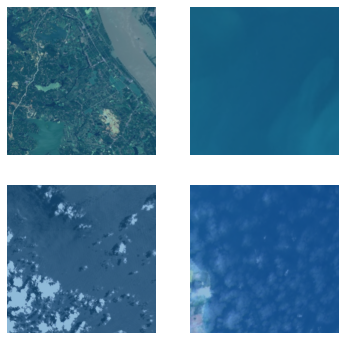

In [15]:
# Swowing a batch of images

src.show_batch(max_n=9, vmin=1, vmax=30)

In [ ]:
# Getting one batch of images and labels

x,y = src.one_batch()

In [ ]:
# Setting the first image from the X

plt.imshow(x.cpu().numpy()[1,0,:,:])

In [ ]:
# Setting the first label from Y

plt.imshow(y.cpu().numpy()[1,:,:])

#  Making the Model

In [16]:
# Using a Unet model for our image segmentation task and using mixed precision for faster training. 

learn = unet_learner(src, xresnet34_deep)#.to_fp16()

#  Making Predictions

In [11]:
#Code to use colab pickled data in windows

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

learn = load_learner("export.pkl")

Found 19 images.


Prediction in process..:   0%|          | 0/19 [00:00<?, ?it/s]

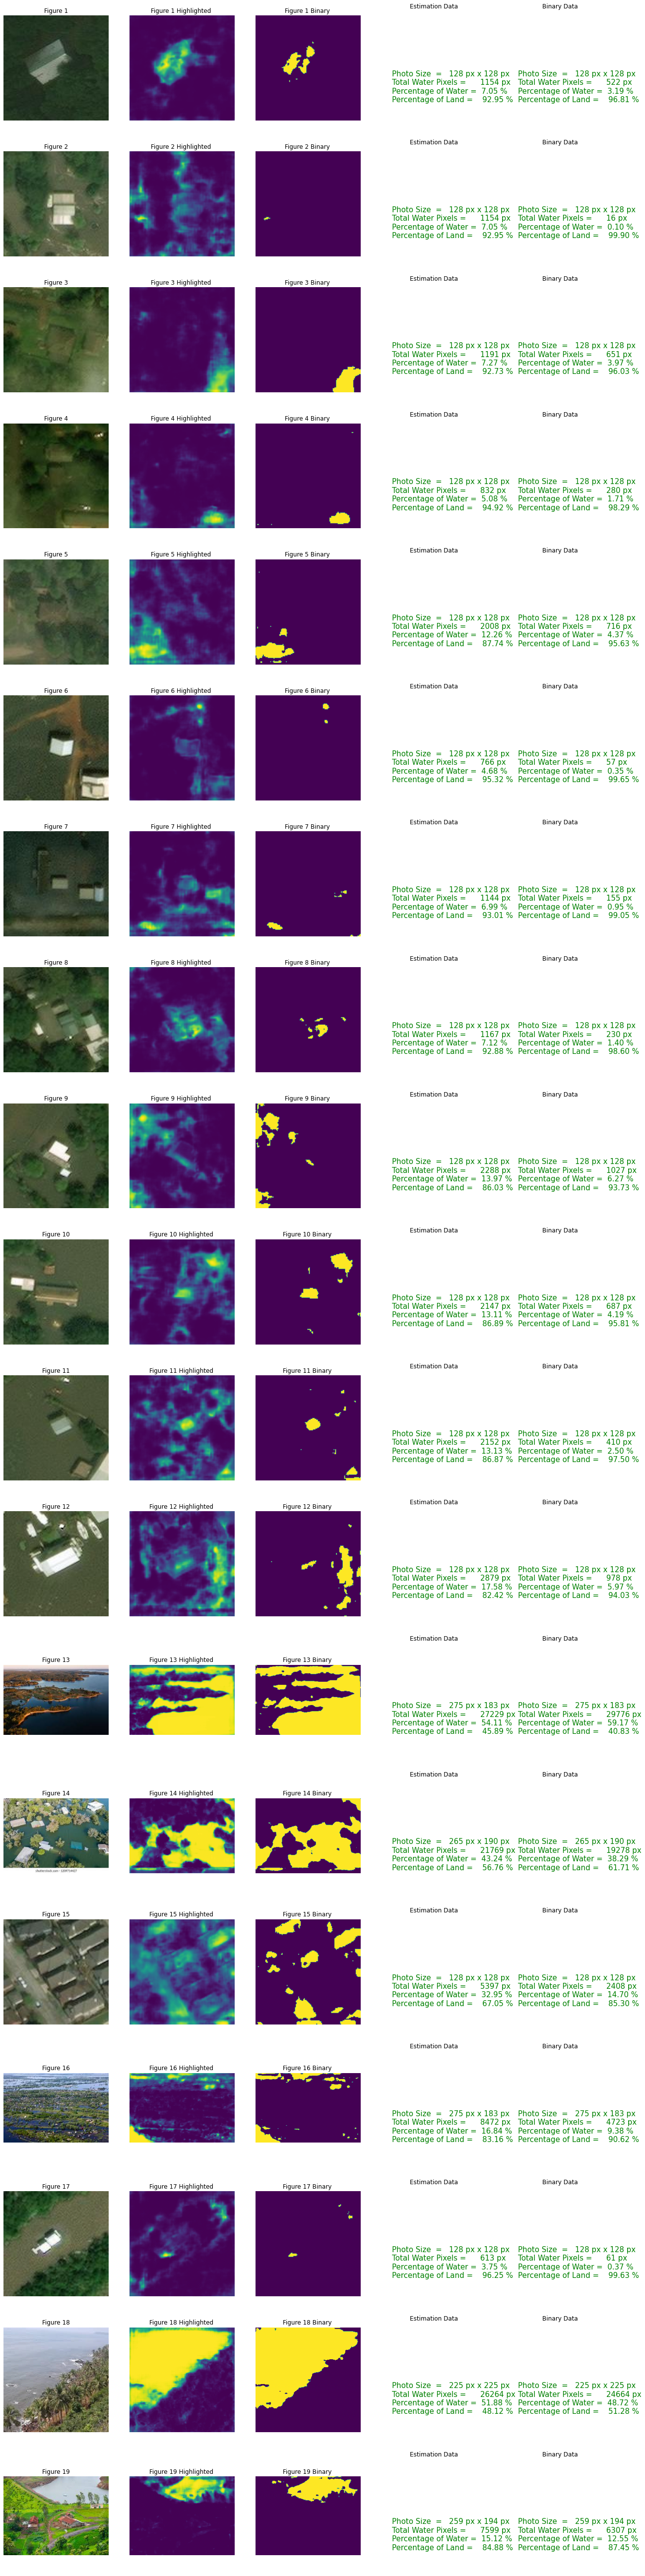

In [12]:
from PIL import Image
from tqdm.notebook import tqdm as tqdm
import numpy
import matplotlib.image as mpimg
import re
import os
from pathlib import Path
import cv2
exit=0
# Reading all image name
path="./images"
try:
    file_list = os.listdir(path)
except:
    print("Directory not found.\nPlease copy the input images to the newly created images folder for prediction.")
    os.mkdir(path)
    exit=1

if not file_list:
    print("No Images found.\nPlease copy the input images to the images folder for prediction.")
    exit=1
else :
    if len(file_list)== 1:
        print("Found "+str(len(file_list))+" image.")
    else:
        print("Found "+str(len(file_list))+" images.")
    
if exit != 1:
    # Sorting the image name
    file_list = sorted(file_list)
    file_list
    #Intialize variables
    img_path = []
    all_pred = []
    row=0
    fig=0
    tfig=1
    col=5

    # Getting all image path
    for i in file_list:
        i = path+"/" + i
        img_path.append(i)
        row=row+1

    #Create Matplot grid
    figure = plt.figure(figsize=(22, row*5))


    #Prediction for every image
    pbar=tqdm(total=row, position=0, desc="Prediction in process..",leave=True)
    for i in img_path:
        water=0  
        count0=0
        count1=0
        fig=fig+1
        img = mpimg.imread(i)

        #Show original image
        figure.add_subplot(row, col, tfig)
        imgplot = plt.imshow(img)
        plt.axis('off')
        t="Figure "+str(fig)
        plt.title(t)
        tfig=tfig+1
        
        predictions = learn.predict(i)     #Run prediction for the batch of images in the folder
        
        #Update progress bar
        pbar.set_description_str("Prediction in process.. Images completed "+str(fig)+" out of "+str(row))
        pbar.update()

        all_pred.append(predictions[1].numpy().flatten()) #creating a dump file for prediction

        #Convert prediction to array
        numpydata = predictions[1].numpy() 
        numpydata2 = predictions[2].numpy()

        #Show Highlighted image
        binimg = Image.fromarray((numpydata2[1]*255).astype(numpy.uint8))
        figure.add_subplot(row, col, tfig)
        plt.imshow(binimg)
        plt.axis('off')
        t="Figure "+str(fig)+" Highlighted "
        plt.title(t)
        tfig=tfig+1

        #Show Binary image
        figure.add_subplot(row, col, tfig)
        plt.imshow(predictions[1])
        plt.axis('off')
        t="Figure "+str(fig)+" Binary "
        plt.title(t)
        tfig=tfig+1

        #Calculate Binary data
        tuple1=numpy.unique(numpydata,return_counts=True)
        ele2 = [ele1 for ele1 in tuple1]  
        try:
            count0=ele2[1][0]
            count1=ele2[1][1]
        except:
            count1=numpydata.size

        #Calculate Estimation data
        imagecal=((numpydata2[1].flatten())*255).astype(numpy.uint8)
        threshold=128
        for n in range(0,255):
            if n<threshold:
                water+=numpy.count_nonzero(imagecal == n)*n/255
            else:
                water+=numpy.count_nonzero(imagecal == n)


        #Show the Estimation data in the 4th column   
        figure.add_subplot(row, col, tfig)
        plt.title("Estimation Data")
        plt.axis('off')
        tfig=tfig+1
        text = r"Photo Size  =   %d px x %d px" % (numpydata2[1].shape[1],numpydata2[1].shape[0]) 
        text += "\n"
        text += r"Total Water Pixels =      %d px" % (water) 
        text += "\n"
        text += r"Percentage of Water =  %.2f %%" % (water*100/imagecal.size) 
        text += "\n"
        text += r"Percentage of Land =    %.2f %%" % ((imagecal.size-water)*100/imagecal.size)
        txt=plt.text(0.1, 0.2, text, color = 'green', fontsize = 15) 
        txt.set_clip_on(False)

        #Show the binary data in the 5th column        
        figure.add_subplot(row, col, tfig)
        plt.axis('off')
        plt.title("Binary Data")
        tfig=tfig+1
        text = r"Photo Size  =   %d px x %d px" % (numpydata.shape[1],numpydata.shape[0]) 
        text += "\n"
        text += r"Total Water Pixels =      %d px" % (count1) 
        text += "\n"
        text += r"Percentage of Water =  %.2f %%" % (count1*100/numpydata.size) 
        text += "\n"
        text += r"Percentage of Land =    %.2f %%" % (count0*100/numpydata.size)
        txt=plt.text(0.1, 0.2, text, color = 'green', fontsize = 15) 
        txt.set_clip_on(False)
    

pbar.set_description_str("Prediction complete. Images completed "+str(fig)+" out of "+str(row))


# Debugging Code

Do not run the below cells, they are for debugging purposes

In [29]:
# Converting all_pred to numpy array
main_array = np.asarray(all_pred)

# Reshaping the array
main_array_flat = np.reshape(main_array,(-1))

# Saving the array to a .npy file
with open("submission_continuous_now.npy", 'wb') as f:
    np.save(f,main_array_flat)
